In [9]:
# imports
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import string
import random

from nltk.corpus import stopwords
from pathlib import Path
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import EnglishStemmer
from gensim.models import Word2Vec as w2v
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import defaultdict

# constantes
ROOT = Path().absolute()
txt_mus = open(ROOT/"data/musicas_short.txt", "r", encoding='utf-8')
lyrics = txt_mus.read()
sw = stopwords.words('english')
plt.style.use('ggplot')

In [10]:
# Lendo o arquivo de texto
songs_list = lyrics.split("\n\nXXXXXXXXXX\n\n")
songs_list.pop()

all_lyrics = []
for song in songs_list:
    lyrics1 = song.split("\n---\n")
    lyrics = lyrics1[0].split("\n>> ") + [lyrics1[1]]
    all_lyrics.append(lyrics)

In [11]:
all_lyrics[315:317]

[["I Can't Make You Love Me",
  'soul',
  "Turn down the lights\nTurn down the bed\nTurn down these voices\nInside my head\n\nLay down with me\nTell me no lies\nJust hold me closely\nDon't patronize\nDon't patronize me\n\n'Cause I can't make you love me if you don't\nAnd you can't make your heart feel something that it won't\nAnd here in the dark, in these final hours\nI will lay down my heart and I will feel the power\nBut you won't, no, you won't\n'Cause I can't make you love me\nWhen you don't, when you don't\n\nI close my eyes\n'Cause then I won't see\nThe love you don't feel\nWhen you're home with me\n\nMorning will come\nAnd I'll do what's right\nJust give me till then\nTo give up this fight\nAnd I will give up this fight\n\n'Cause I can't make you love me if you don't\nAnd you can't make your heart feel something that it won't\nAnd here in the dark, in these final hours\nI will lay down my heart and I will feel the power\nBut you won't, no, you won't\n'Cause I can't make you lov

In [12]:
# Limpando e tokenizando os textos
swu = stopwords.words('english') + list(string.punctuation)
stemmer = EnglishStemmer()

clean_lyrics = {'titulo': [], 'titulo tokenizado':[], 'musica completa':[], 'musica':[], 'genero':[]}
tokenizador = WordPunctTokenizer()

for song in all_lyrics:
    current_song = []
    current_title = []
    song_lower = song[2].lower()
    title_lower = song[0].lower()
    genre = song[1]
    for token in tokenizador.tokenize(song_lower):
        if (token not in swu):
            current_song.append(stemmer.stem(token))
    for token in tokenizador.tokenize(title_lower):
        if (token not in list(string.punctuation)):
            # Inclui apenas pontuação porque, como os títulos tendem a ter
            # menos palavras (e, muitas delas, stopwords), perde-se muita
            # informação ao excluir as stopwords.
            current_title.append(stemmer.stem(token))
    clean_lyrics['titulo'].append(title_lower)
    clean_lyrics['titulo tokenizado'].append(current_title)
    clean_lyrics['musica completa'].append(song[2])
    clean_lyrics['musica'].append(current_song)
    clean_lyrics['genero'].append(genre)

lyrics_df = pd.DataFrame(data = clean_lyrics)
lyrics_df.head()

,titulo,titulo tokenizado,musica completa,musica,genero
0,34+35,"[34, 35]",Hmm\n\nYou might think I'm crazy\nThe way I've...,"[hmm, might, think, crazi, way, cravin, put, q...",pop
1,34+35 (remix) (feat. megan thee stallion &amp;...,"[34, 35, remix, feat, megan, thee, stallion, a...",[Ariana Grande]\nHmm\n\nYou might think I'm cr...,"[ariana, grand, hmm, might, think, crazi, way,...",pop
2,7 rings,"[7, ring]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop
3,7 rings (live),"[7, ring, live]",Thank you\nDo you mind if we change our costum...,"[thank, mind, chang, costum, real, fast, got, ...",pop
4,7 rings (remix) (feat. 2 chainz),"[7, ring, remix, feat, 2, chainz]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop


In [13]:
lyrics_df['genero'].unique()

array(['pop', 'soul', 'indie', 'eletronica', 'pop rock', 'rock and roll',
       'hard rock', 'reggae', 'heavy metal', 'gospel', 'hip hop/rap',
       'punk rock', 'alternativo', 'folk'], dtype=object)

In [34]:
lyrics_df.groupby('genero').count()['musica'].sort_values(ascending=False)

genero
pop rock         1345
rock and roll    1310
pop              1259
gospel            965
eletronica        902
heavy metal       718
hip hop/rap       698
indie             642
hard rock         461
alternativo       319
punk rock         295
reggae            217
soul              162
folk               47
Name: musica, dtype: int64

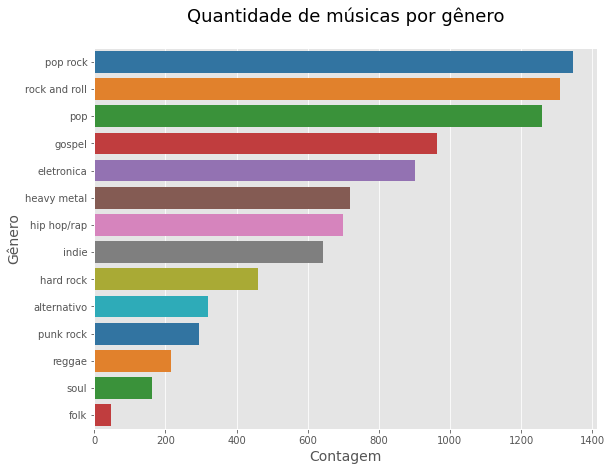

In [43]:
target = lyrics_df.groupby('genero').count()['musica'].sort_values(ascending=False).index
count = lyrics_df.groupby('genero').count()['musica'].sort_values(ascending=False).values

plt.figure(figsize = (9, 7))
sns.barplot(x=count, y=target, palette='tab10')
plt.xlabel('Contagem', size=14)
plt.ylabel('Gênero', size=14)
plt.title('Quantidade de músicas por gênero\n', size=18)
plt.show()

### Tentativa de reorganizar as classificações e diminuir a quantidade de classes existentes
Como o corpus apresenta, no total, 14 gêneros musicais diferentes, utilizar uma regressão logística para fazer a classificação dos dados pode retornar resultados menos precisos, afinal muitos dos gêneros apresentados são muito semelhantes entre si. Nesse sentido, optou-se por fazer uma reorganização dos dados a fim de dimunuir o número de categorias.

Primeiramente, foram excluídos alguns gêneros com menos ocorrências e menos informção contida nas letras (por exemplo, músicas eletrônicas, que em geral têm menos texto), para facilitar as análises. Além disso, músicas de gêneros que não conseguiram ser facilmente encaixados nas categorias criadas mais abaixo também foram descartados. Logo, foram as seguintes categorias:
* eletronica
* reggae
* heavy metal
* punk rock
* soul

Em seguida, optou-se por reunir alguns gêneros semelhantes sob uma mesma categoria. Utiliazndo inteiros de 0 a 5, os gêneros presentes na tabela foram agrupados da seguinte forma:
* pop, pop rock -> pop (0)
* rock and roll, hard rock -> rock (1)
* indie, alternativo, folk -> indie/alternativo (2)
* hip hop/rap -> hip hop/rap (3)
* gospel -> gospel (4)
* eletronica, reggae, heavy metal, punk rock, soul -> excluídos do dataframe (5)

In [44]:
dicio_target = {'pop':0, 'soul':5, 'indie':2, 'eletronica':5, 'pop rock':0, 'rock and roll':1,\
                'hard rock':1, 'reggae':5, 'heavy metal':5, 'gospel':4, 'hip hop/rap':3,\
                'punk rock':5, 'alternativo':2, 'folk':2}

lyrics_df['Target'] = lyrics_df.apply(lambda x: dicio_target[x['genero']], axis=1)
lyrics_df

,titulo,titulo tokenizado,musica completa,musica,genero,Target
0,34+35,"[34, 35]",Hmm\n\nYou might think I'm crazy\nThe way I've...,"[hmm, might, think, crazi, way, cravin, put, q...",pop,0
1,34+35 (remix) (feat. megan thee stallion &amp;...,"[34, 35, remix, feat, megan, thee, stallion, a...",[Ariana Grande]\nHmm\n\nYou might think I'm cr...,"[ariana, grand, hmm, might, think, crazi, way,...",pop,0
2,7 rings,"[7, ring]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
3,7 rings (live),"[7, ring, live]",Thank you\nDo you mind if we change our costum...,"[thank, mind, chang, costum, real, fast, got, ...",pop,0
4,7 rings (remix) (feat. 2 chainz),"[7, ring, remix, feat, 2, chainz]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
...,...,...,...,...,...,...
9335,we all die trying to get it right,"[we, all, die, tri, to, get, it, right]",Think you're in control until you're not\nAnd ...,"[think, control, love, find, place, alon, find...",folk,2
9336,we're going home,"[we, re, go, home]",Under the surface you don't know what you'll f...,"[surfac, know, find, hmm, time, second, chanc,...",folk,2
9337,where we start,"[where, we, start]",Storm rolled in to our surprise\nIt doesn't ra...,"[storm, roll, surpris, rain, tall, tree, love,...",folk,2
9338,who am i,"[who, am, i]",Hold me up to the light\nTell me if the sun co...,"[hold, light, tell, sun, come, shine, got, hea...",folk,2


In [45]:
# Excluindo a categoria 5
lyrics_df = lyrics_df.loc[lyrics_df['Target'] != 5].reset_index().drop(columns='index')
lyrics_df

,titulo,titulo tokenizado,musica completa,musica,genero,Target
0,34+35,"[34, 35]",Hmm\n\nYou might think I'm crazy\nThe way I've...,"[hmm, might, think, crazi, way, cravin, put, q...",pop,0
1,34+35 (remix) (feat. megan thee stallion &amp;...,"[34, 35, remix, feat, megan, thee, stallion, a...",[Ariana Grande]\nHmm\n\nYou might think I'm cr...,"[ariana, grand, hmm, might, think, crazi, way,...",pop,0
2,7 rings,"[7, ring]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
3,7 rings (live),"[7, ring, live]",Thank you\nDo you mind if we change our costum...,"[thank, mind, chang, costum, real, fast, got, ...",pop,0
4,7 rings (remix) (feat. 2 chainz),"[7, ring, remix, feat, 2, chainz]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
...,...,...,...,...,...,...
7041,we all die trying to get it right,"[we, all, die, tri, to, get, it, right]",Think you're in control until you're not\nAnd ...,"[think, control, love, find, place, alon, find...",folk,2
7042,we're going home,"[we, re, go, home]",Under the surface you don't know what you'll f...,"[surfac, know, find, hmm, time, second, chanc,...",folk,2
7043,where we start,"[where, we, start]",Storm rolled in to our surprise\nIt doesn't ra...,"[storm, roll, surpris, rain, tall, tree, love,...",folk,2
7044,who am i,"[who, am, i]",Hold me up to the light\nTell me if the sun co...,"[hold, light, tell, sun, come, shine, got, hea...",folk,2


### Breve análise exploratória dos dados

A partir do dataset já limpo e recategorizado, foram construídos alguns gráficos a fim explorar as principais características dos dados.

In [56]:
count_df = lyrics_df.groupby('Target').count()
count_df = count_df['musica'].sort_values(ascending=False)
count_df.index

Int64Index([0, 1, 2, 4, 3], dtype='int64', name='Target')

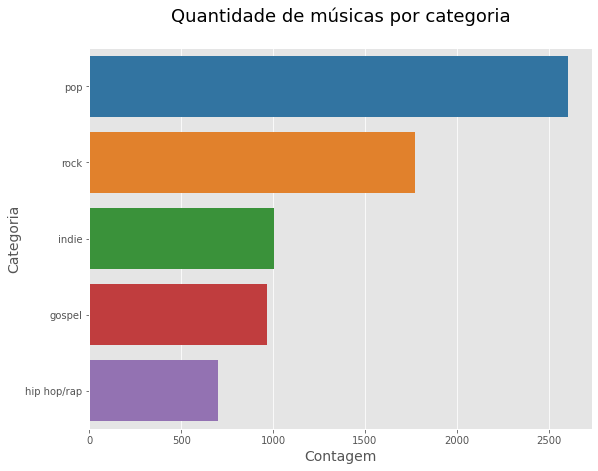

In [66]:
dicio_target = {0: 'pop',1:'rock',2:'indie', 3:'hip hop/rap', 4:'gospel'}
target_int = count_df.index
target = [dicio_target[idx] for idx in target_int.tolist()]
count = count_df.values

# sns.barplot(x=count, y=target, palette='husl').set(title = 'Quantidade de músicas por categoria\n')

plt.figure(figsize = (9, 7))
sns.barplot(x=count, y=target, palette='tab10')
plt.xlabel('Contagem', size=14)
plt.ylabel('Categoria', size=14)
plt.title('Quantidade de músicas por categoria\n', size=18)
plt.show()

### Brincando com os modelos do Word2Vec

In [68]:
titles_list =  lyrics_df['titulo tokenizado'].tolist()
lyrics_list = lyrics_df['musica'].tolist()

In [69]:
titles_model = w2v(titles_list, min_count=5)
lyrics_model = w2v(lyrics_list, min_count=25)

def similar(word, where=1):
    if where == 0:  # considera o título das músicas
        similar = titles_model.wv.most_similar(stemmer.stem(word))
    elif where == 1:  # considera a letra das músicas
        similar = lyrics_model.wv.most_similar(stemmer.stem(word))
    return similar

In [71]:
similar('lover')

[('kind', 0.5848154425621033),
 ('dancer', 0.5244021415710449),
 ('wolf', 0.5117327570915222),
 ('deepli', 0.48143598437309265),
 ('surfac', 0.45446568727493286),
 ('mother', 0.4536292254924774),
 ('mend', 0.44918110966682434),
 ('anger', 0.4461888074874878),
 ('underneath', 0.4314558804035187),
 ('present', 0.42515987157821655)]

In [72]:
similar('talk')

[('languag', 0.5865907073020935),
 ('tough', 0.5368690490722656),
 ('listen', 0.5050937533378601),
 ('talkin', 0.4892454147338867),
 ('curv', 0.47976693511009216),
 ('walk', 0.46913841366767883),
 ('monkey', 0.4582293927669525),
 ('speak', 0.42511677742004395),
 ('bout', 0.42380884289741516),
 ('ego', 0.4119383692741394)]

In [73]:
similar('money')

[('spend', 0.6645798683166504),
 ('cash', 0.6157851815223694),
 ('rent', 0.5863938331604004),
 ('earn', 0.584719717502594),
 ('dolla', 0.5819085240364075),
 ('bill', 0.5663626194000244),
 ('bread', 0.5660426616668701),
 ('colleg', 0.555345356464386),
 ('dollar', 0.5501088500022888),
 ('daili', 0.5455799698829651)]

In [74]:
similar('dead')

[('buri', 0.7131282687187195),
 ('woke', 0.548803448677063),
 ('led', 0.5366547703742981),
 ('awak', 0.4956878423690796),
 ('death', 0.4934784770011902),
 ('arriv', 0.49154767394065857),
 ('cave', 0.48680368065834045),
 ('flower', 0.4799598753452301),
 ('bloom', 0.47936367988586426),
 ('hang', 0.47824156284332275)]

In [75]:
similar('god')

[('bless', 0.8568189740180969),
 ('almighti', 0.7704364061355591),
 ('overcom', 0.6415073871612549),
 ('reign', 0.6371095776557922),
 ('emmanuel', 0.6268636584281921),
 ('worship', 0.6231434345245361),
 ('mighti', 0.6219316720962524),
 ('glori', 0.6071105599403381),
 ('overwhelm', 0.6039947271347046),
 ('majesti', 0.6023054122924805)]

## Usando Word2Vec para fazer a classificação

In [86]:
# Separando conjunto de treinamento e de teste:
X_train, X_test, y_train, y_test = train_test_split(lyrics_df['musica'], lyrics_df['Target'], test_size=0.3, shuffle=True)

In [87]:
X_train 

3582    [look, morn, rain, use, feel, uninspir, knew, ...
6080    [presenc, full, life, heal, flow, bodi, soul, ...
2821    [break, power, sin, dark, whose, love, mighti,...
5304    [go, home, alon, drive, past, place, born, pla...
2039    [look, african, queen, eat, twelv, chapatti, c...
                              ...                        
4622    [met, upon, hill, night, cool, still, suck, do...
2348    [hell, rais, leather, five, year, stood, black...
3190    [babi, yeah, got, babi, yeah, got, babi, yeah,...
6269    [everi, soul, everi, beat, heart, everi, natio...
158     [mu, mu, mu, murda, tell, get, feel, realli, w...
Name: musica, Length: 4932, dtype: object

In [88]:
y_train 

3582    0
6080    4
2821    4
5304    2
2039    1
       ..
4622    0
2348    1
3190    0
6269    4
158     0
Name: Target, Length: 4932, dtype: int64

In [89]:
# Deixando os dados no formato necessário para a aplicação dos modelos do scikit learn
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def transform(self, X):
        '''
        Transforma os dados textuais em dados numéricos, vetorizando as palavras
        de cada música.
        '''
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] \
            or [np.zeros(self.dim)], axis=0) for words in X])

model = w2v(lyrics_df['musica'], min_count=1)
w2vec = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2vec)
X_train_ = modelw.transform(X_train)
X_test_ = modelw.transform(X_test)

In [90]:
X_train_ 

array([[ 0.00120026, -0.0989248 ,  0.20190349, ..., -0.24406607,
        -0.83880788,  0.31492993],
       [-0.02194807, -0.13753413,  0.05744245, ..., -0.20531565,
        -0.69334996,  0.00651305],
       [-0.23664382,  0.29350558,  0.45998028, ..., -0.34044108,
        -0.14018109,  0.30950543],
       ...,
       [ 0.12189651, -0.02169093,  0.06861567, ..., -0.61171436,
        -0.30588704,  0.44884512],
       [-0.15678142,  0.08132638,  0.4634029 , ..., -0.19782563,
        -0.39832354,  0.27117309],
       [ 0.07880162,  0.03684461,  0.18241239, ..., -0.32663488,
        -0.29280978,  0.05144956]])

Foram treinados dois modelos: o primeiro (``regressao_modelo1``) leva em consideração a diferença no número de ocorrências
dentro de cada classe, atribuindo pesos distintos para cada categoria a depender desse valor; já o segundo modelo (``regressao_modelo2``)
não o faz.

In [91]:
# Definindo os modelos:
regressao_modelo1 = LogisticRegression(solver = 'newton-cg', class_weight='balanced')
regressao_modelo2 = LogisticRegression(solver = 'newton-cg')
# Treinando os modelos:
regressao_modelo1.fit(X_train_, y_train)
regressao_modelo2.fit(X_train_, y_train)

LogisticRegression(solver='newton-cg')

In [92]:
y_pred1 = regressao_modelo1.predict(X_test_)
y_pred2 = regressao_modelo2.predict(X_test_)

In [99]:
print('>> Modelo 1 (considerando diferença no tamanho das classes):\n\n', classification_report(y_test, y_pred1), \
    '\n---\n', '\n>> Modelo 2 (não considerando diferença no tamanho das classes):\n\n', classification_report(y_test, y_pred2))

>> Modelo 1 (considerando diferença no tamanho das classes):

               precision    recall  f1-score   support

           0       0.64      0.38      0.48       775
           1       0.55      0.46      0.50       546
           2       0.24      0.43      0.31       277
           3       0.46      0.79      0.58       206
           4       0.84      0.94      0.88       310

    accuracy                           0.53      2114
   macro avg       0.55      0.60      0.55      2114
weighted avg       0.58      0.53      0.53      2114
 
---
 
>> Modelo 2 (não considerando diferença no tamanho das classes):

               precision    recall  f1-score   support

           0       0.53      0.73      0.61       775
           1       0.56      0.45      0.50       546
           2       0.23      0.10      0.14       277
           3       0.67      0.54      0.60       206
           4       0.88      0.90      0.89       310

    accuracy                           0.58     

Segundo modelo: recall bem baixo -> o modelo deixou passar muitas músicas da categoria indie/alternativa

Ambos os modelos foram piores para lidar com a categoria indie/alternativa, foram melhores (porém ainda ruins) para lidar com as categorias
pop, rock e hip hop/rap, mas apresentaram ótimos resultados lidando com a categoria gospel.

In [101]:
print(X_test)
print('\n')
print(y_test)

3444    [second, walk, room, leg, start, shake, blood,...
111     [never, thought, simpl, found, way, found, way...
55      [got, weak, decid, would, check, say, hello, l...
1261    [noth, like, real, thing, babi, noth, like, re...
3718    [beach, good, place, pick, girl, realli, see, ...
                              ...                        
6303    [shelter, hous, go, spirit, god, glow, rest, p...
6395    [vers, 1, whenev, see, face, fear, fli, whenev...
5356    [well, gear, walkin, street, feel, slime, drip...
3065    [’, gonna, get, gonna, get, togeth, ’, gonna, ...
320     [pin, dark, fight, sheet, near, cri, sleep, ye...
Name: musica, Length: 2114, dtype: object


3444    0
111     0
55      0
1261    0
3718    0
       ..
6303    4
6395    4
5356    1
3065    0
320     2
Name: Target, Length: 2114, dtype: int64


In [103]:
print(lyrics_df.iloc[3444]) # primeira música do conjunto de teste
print('\n')
print(f'Modelo 1: {y_pred1[0]}, Modelo 2: {y_pred2[0]}')

titulo                                                           bones
titulo tokenizado                                               [bone]
musica completa      The second you walked in the room, my legs sta...
musica               [second, walk, room, leg, start, shake, blood,...
genero                                                        pop rock
Target                                                               0
Name: 3444, dtype: object


Modelo 1: 0, Modelo 2: 0


No caso acima, podemos ver que ambos os modelos acertaram a previsão.

Por fim, testando com uma última música:

In [104]:
boss_final = lyrics_df.loc[lyrics_df['titulo'] == 'take me to church']
boss_final = boss_final['musica']

In [106]:
boss_final1 = lyrics_df.loc[lyrics_df['titulo'] == 'take me to church']
boss_final = boss_final1['musica']

modelo_teste = w2v(boss_final,min_count=1)
w2vec_teste = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw_teste = MeanEmbeddingVectorizer(w2vec_teste)
boss_final_ = modelw_teste.transform(boss_final)
boss_final_

array([[ 0.06629094, -0.03711534,  0.05951777, -0.28147966, -0.03757274,
        -0.46364433,  0.12307993,  0.41165465, -0.38287804, -0.544488  ,
        -0.25042218, -0.5088017 ,  0.31273386,  0.4291813 , -0.35255682,
         0.18168949,  0.22267887, -0.30262965, -0.4895625 , -0.33097106,
         0.08654214, -0.5066243 ,  0.00537932, -0.0386173 , -0.16988179,
         0.14773019, -0.6186023 , -0.33915007, -0.6300532 , -0.13404459,
         0.20835465,  0.26227346,  0.3603134 , -0.41073704,  0.14502   ,
         0.5304364 ,  0.33668327, -0.24228233, -0.41800037, -0.1571959 ,
        -0.40512118, -0.16028367, -0.5911089 ,  0.44954458,  0.2256311 ,
         0.11772861, -0.35365653, -0.13652313,  0.22157906,  0.38444117,
         0.29276535,  0.11603554, -0.4531159 , -0.21500343, -0.16652325,
         0.20627052,  0.13610134, -0.15291421,  0.11182084, -0.06971484,
         0.14189719, -0.42437902,  0.1926834 ,  0.10237315, -0.44677433,
         0.21487524,  0.36387095, -0.13594054, -0.1

In [110]:
regressao_modelo1.predict(boss_final_)  # Modelo que considera a quantidade de músicas por categoria

array([4, 1, 4], dtype=int64)

In [120]:
regressao_modelo2.predict(boss_final_)  # Modelo que não considera quantidade

array([0, 1, 0], dtype=int64)

In [115]:
boss_final1

,titulo,titulo tokenizado,musica completa,musica,genero,Target
3645,take me to church,"[take, me, to, church]",My lover's got humour\nShe's the giggle at a f...,"[lover, got, humour, giggl, funer, know, every...",pop rock,0
4946,take me to church,"[take, me, to, church]","Yeah, yeah, yeah, yeah, yeah\nMy lover's got h...","[yeah, yeah, yeah, yeah, yeah, lover, got, hum...",pop,0
6476,take me to church,"[take, me, to, church]",My lover's got humour\nShe's the giggle at a f...,"[lover, got, humour, giggl, funer, know, every...",alternativo,2


In [119]:
boss_final1.iloc[1]['musica completa']

"Yeah, yeah, yeah, yeah, yeah\nMy lover's got humour\nShe's the giggle at a funeral\nKnows everybody's disapproval\nI should've worshipped her sooner\n\nIf the heavens ever did speak\nShe is the last true mouthpiece\nEvery Sunday's getting more bleak\nA fresh poison each week\n\nWe were born sick\nBut I love it\nCommand me to be well\nAmen, amen, amen\n\nTake me to church\nI'll worship like a dog at the shrine of your lies\nI'll tell you my sins\nSo you can sharpen your knife\nOffer me that deathless death\nGood God, let me give you my life\n\nIf I'm a pagan of the good times\nMy lover's the sunlight\nTo keep the goddess on my side\nShe demands a sacrifice\nThat looks tasty\nThat looks plenty\nThis is hungry work\n\nTake me to church\nI'll worship like a dog at the shrine of your lies\nI'll tell you my sins\nSo you can sharpen your knife\nOffer me my deathless death\nGood God, let me give you my life\n\nTake me to church\nI'll worship like a dog at the shrine of your lies\nI'll tell yo

No caso acima, uma mesma música (regravada por artistas que tocam gêneros diferentes) resultou em classificações distintas pelo modelo treinado,
provavelmente devido a pequenas alterações na letra, como a presença do trecho "yeah, yeah, yeah" na segunda música.